In [88]:
import backtrader as bt

import backtrader.indicators as btind
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from datetime import datetime, timedelta
from sklearn import svm
import pandas as pd
import math
from sklearn import preprocessing
from math import sqrt
from technicalSignals import momentum,SMA,inBBands


In [89]:
tickers=['AAPL','AMZN','PEP','GOOGL','MSFT','FB','INTC','CSCO','CMCSA','NVDA','NFLX','BKNG','ADBE','AMGN','TXN','AVGO','PYPL','GILD','COST','QCOM']       
meanprice=list()
for ticker in tickers:
    price=pd.read_csv('/home/andrea/Desktop/NLFF/TechnicalDatasetUpdated/GMT+0/'+ticker+'.csv')
    meanprice.append(price['open'].iloc[math.floor(len(price)*0.9)])
print(meanprice)

[187.31, 1581.57, 100.0, 1080.44, 97.4647, 183.88, 54.49, 43.84, 32.57, 241.99, 332.93, 2130.65, 239.21, 178.69, 111.27, 239.442, 80.34, 68.21, 199.1278, 57.42]


In [108]:
# ===========================================    Trading Library utilities

    
# class Sizer(bt.Sizer):
#     params = dict(stake=1)

#     def _getsizing(self, comminfo, cash, data, isbuy):
#         dt, i = self.strategy.datetime.date(), data._id
#         s = self.p.stake * (1 + (not isbuy))
#         print('{} Data {} OType {} Sizing to {}'.format(
#             dt, data._name, ('buy' * isbuy) or 'sell', s))

#         return s

    
class Strategy(bt.Strategy):
    params = dict(
        pred_threshold = None,        #buy if prediction more than this threshold (prediction values normalized 1: most secure prediction)
        num_pred_over_threshold = None, #buy if more than this number of prediction over threshold
        forecast_window = None,
        pred_threshold_pos=None,
        pred_threshold_neg=None,
        predictions = None,
        verbose = None,
        tol=None,
        value=None
    )

    def log(self, txt, dt=None):
        dt = dt or self.datetime.datetime().strftime('%Y-%m-%d %H:%M:%S')
        print('%s, %s' % (dt, txt))

    def notify_order(self, order):
        if self.verbose:
            if order.status in [order.Submitted, order.Accepted]:
                return
            if order.status in [order.Completed]:
                if order.isbuy():
                    self.log('BUY EXECUTED, %.2f' % order.executed.price)
                elif order.issell():
                    self.log('SELL EXECUTED, %.2f' % order.executed.price)
            elif order.status in [order.Canceled, order.Margin, order.Rejected]:
                self.log('Order Canceled/Margin/Rejected')

        
    def __init__(self):
        self.planned_sell = {}  # PLANNED SELL FOR EACH BUY AFTER TREND WINDOW dict: selldate, stock -> amount
        self.forecast_window = self.params.forecast_window
        self.predictions = self.params.predictions
        self.pred_threshold=self.params.pred_threshold
        
        self.num_pred_over_threshold = self.params.num_pred_over_threshold
        self.verbose = self.params.verbose
        self.tol = self.params.tol
        self.value=self.params.value
        

    def next(self): 
        positions = {}
        for i, d in enumerate(self.datas):
            #dt = self.datetime.date()
            dt = self.datetime.datetime().strftime('%Y-%m-%d %H:%M:%S')
            
            if(len((np.where(self.predictions[i]['Unnamed: 0']==dt)[0]))>0):
                time_idx = np.where(self.predictions[i]['Unnamed: 0']==dt)[0][0]
                dn = d._name
                ticker_pred = self.predictions[i][d._name][time_idx]

                previous_pred = self.predictions[i][d._name].iloc[time_idx-self.num_pred_over_threshold:time_idx]

                previous_pred_pos = sum([1 if p>0.5+self.pred_threshold else 0 for p in previous_pred]) #count prev over threshold
                previous_pred_neg = sum([1 if p<0.5-self.pred_threshold else 0 for p in previous_pred])
                pos = self.getposition(d).size
                positions[dn]=pos
                # Strategy: buy if abs(pred)> threshold or if more than n predictions positive
                quantity=math.ceil(self.value/(140*len(tickers)*meanprice[i]))*10
                
                
                if(ticker_pred>self.pred_threshold+0.5 or ticker_pred<0.5-self.pred_threshold):
                    # Buy and set planned sell if prediction positive
                    if(ticker_pred > 0.5 and previous_pred_pos>=self.num_pred_over_threshold*self.tol):
                        self.buy(data = d, size=quantity)                
                        idx_to_sell = time_idx+self.forecast_window
                        self.planned_sell[(dn,idx_to_sell)] = quantity
                    elif(ticker_pred<0.5 and previous_pred_neg>=self.num_pred_over_threshold*self.tol):
                        self.sell(data = d, size=quantity)                
                        idx_to_sell = time_idx+self.forecast_window
                        self.planned_sell[(dn,idx_to_sell)] = -quantity
                #Execute sell planned for now
                if (dn,time_idx) in self.planned_sell:
                    amount = self.planned_sell[(dn,time_idx)]
                    if(amount>0):
                        self.sell(data = d, size=amount)
                    else:
                        self.buy(data = d, size=amount)
                    del self.planned_sell[(dn,time_idx)] 
            
        if self.verbose:
                print('{} Positions {}'.format(dt, positions))

                
                
                
def printTradeAnalysis(analyzer):
    total_open = analyzer.total.open
    total_closed = analyzer.total.closed
    total_won = analyzer.won.total
    total_lost = analyzer.lost.total
    win_streak = analyzer.streak.won.longest
    lose_streak = analyzer.streak.lost.longest
    pnl_net = round(analyzer.pnl.net.total,2)
    strike_rate = (total_won / total_closed) * 100
    h1 = ['Total Open', 'Total Closed', 'Total Won', 'Total Lost']
    h2 = ['Strike Rate','Win Streak', 'Losing Streak', 'PnL Net']
    r1 = [total_open, total_closed,total_won,total_lost]
    r2 = [strike_rate, win_streak, lose_streak, pnl_net]
    if len(h1) > len(h2):
        header_length = len(h1)
    else:
        header_length = len(h2)
    print_list = [h1,r1,h2,r2]
    row_format ="{:<15}" * (header_length + 1)
    print("Trade Analysis Results:")
    for row in print_list:
        print(row_format.format('',*row))

def printSQN(analyzer):
    sqn = round(analyzer.sqn,2)
    print('SQN: {}'.format(sqn))
def get_hist_broker(strategy):
    i=1
    portfolioValue = []
    cash = []
    while not np.isnan(strategy.stats.broker.value.array[i]):
        portfolioValue.append(strategy.stats.broker.value.array[i])
        cash.append(strategy.stats.broker.cash.array[i])
        i += 1
        
    return (np.asarray(portfolioValue),np.asarray(cash))    
def annualizedReturn(Return):
    annualized=((1+Return)**(365/59))-1
    return annualized
def compute_SharpeRatio(strategy,ret):
    (portfolioValue, cash) = get_hist_broker(strategy)
    returns = np.asarray(list(strategy.analyzers.returns.get_analysis().values()))
    
    sharpe = (ret-0.004526)/np.std(returns)
    return sharpe


In [109]:
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 30, 20  # that's default image size for this interactive session
pylab.rcParams['font.family'] = 'sans-serif'
pylab.rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
pylab.rcParams['font.serif'] = ['Bitstream Vera Sans']
pylab.rcParams["font.size"] = "30"

In [119]:
def simulation(treshold,n_predict_over,init_val,tickers,tollerance,source):
    pred_threshold =treshold        #buy if prediction more than this threshold (prediction values normalized 1: most secure prediction)
    num_pred_over_threshold = n_predict_over  #buy if more than this number of prediction over threshold
    init_value = init_val



    cerebro = bt.Cerebro(stdstats=False)
    cerebro.addobservermulti(bt.observers.BuySell)
    cerebro.addobserver(bt.observers.CashValue)
    cerebro.addobserver(bt.observers.DrawDown)
    cerebro.addobserver(bt.observers.Broker)
    cerebro.broker.setcash(init_value)
    cerebro.broker.setcommission(commission=0.0001)
    predictions=list() 

    evenPlot = True
    for ticker in tickers:
        temppred=pd.read_csv('/home/andrea/Desktop/NLFF/technicalAnalysis/NN/Predictions/Affective/gscore-1000/'+source+'/'+ticker+'.csv')
        predictions.append(temppred)
        #plt.hist(temppred[ticker], bins = np.arange(0.0, 1.0, 0.01))
        #plt.show()
        dates_test = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in temppred['Unnamed: 0']]
        data = bt.feeds.GenericCSVData(
                    dataname='/home/andrea/Desktop/NLFF/TechnicalDataset/GMT+0/'+ticker+'.csv',
                    name=ticker,
                    value=init_value,
                    timeframe = bt.TimeFrame.Minutes, 
                    compression = 15,
                    datetime=1,open=2,high=3,low=4,close=5,volume=6,openinterest=-1,
                    fromdate=dates_test[0],
                    todate=dates_test[-1]+timedelta(minutes=1),
                    reverse=False)
    #         if(evenPlot):
    #             data0 = data
    #             evenPlot = False
    #         else:
    #             data.plotinfo.plotmaster = data0
    #             evenPlot = True
        cerebro.adddata(data)

    #cerebro.addsizer(Sizer)    
     #Up to now only future
    cerebro.addstrategy(Strategy,
                        pred_threshold = pred_threshold,
                        num_pred_over_threshold = num_pred_over_threshold,
                        forecast_window=140,
                        predictions = predictions,
                        verbose = False,
                        tol=tollerance,
                        value=init_value)
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="ta")
    cerebro.addanalyzer(bt.analyzers.SQN, _name="sqn")
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharp',timeframe=bt.TimeFrame.Minutes, compression=15,riskfreerate=0.0000028,convertrate=False)
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown') 
    cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='returns')


    #print('Starting Portfolio Value: %.2f' % init_value)
    strategy = cerebro.run()[0]
    final_value = cerebro.broker.getvalue()
    #cerebro.plot()
    printTradeAnalysis(strategy.analyzers.ta.get_analysis())
    ann=annualizedReturn((final_value-init_value)/init_value)
    print('Sharp ratio: ',strategy.analyzers.sharp.get_analysis())
    print('Max drwadown: ',strategy.analyzers.drawdown.get_analysis())
    printSQN(strategy.analyzers.sqn.get_analysis())
    print('Final Portfolio Value: %.2f \nGain: %.2f' % (final_value, (100*(final_value-init_value))/init_value))
    print('Annualized Return:',ann)
    return((100*(final_value-init_value))/init_value)

In [120]:
simulation(0.4,0,1000000,tickers,1,'news')

Trade Analysis Results:
               Total Open     Total Closed   Total Won      Total Lost     
               20             65             34             34             
               Strike Rate    Win Streak     Losing Streak  PnL Net        
               52.3076923076923147              7              16058.41       
Sharp ratio:  OrderedDict([('sharperatio', 0.03325149601620163)])
Max drwadown:  AutoOrderedDict([('len', 149), ('drawdown', 1.4409549093244314), ('moneydown', 15484.181391399121), ('max', AutoOrderedDict([('len', 149), ('drawdown', 3.708175703413133), ('moneydown', 39847.232450700016)]))])
SQN: 0.61
Final Portfolio Value: 1059093.61 
Gain: 5.91
Annualized Return: 0.4264444207603


5.9093606657404685

Sharp ratio:  OrderedDict([('sharperatio', 0.02597718343290896)])
Max drwadown:  AutoOrderedDict([('len', 128), ('drawdown', 2.113915198454764), ('moneydown', 22755.643940589158), ('max', AutoOrderedDict([('len', 128), ('drawdown', 4.266063597629134), ('moneydown', 45922.85647339071)]))])
SQN: 0.57
Final Portfolio Value: 1053713.46 
Gain: 5.37
Sharp ratio:  OrderedDict([('sharperatio', 0.02554394789332106)])
Max drwadown:  AutoOrderedDict([('len', 38), ('drawdown', 1.953721349919106), ('moneydown', 20979.680173899513), ('max', AutoOrderedDict([('len', 89), ('drawdown', 4.352770708392916), ('moneydown', 46736.37305338937)]))])
SQN: -0.1
Final Portfolio Value: 1052852.07 
Gain: 5.29
Sharp ratio:  OrderedDict([('sharperatio', 0.02422004754804113)])
Max drwadown:  AutoOrderedDict([('len', 128), ('drawdown', 2.460240563218311), ('moneydown', 26470.86909258808), ('max', AutoOrderedDict([('len', 128), ('drawdown', 4.295913499379681), ('moneydown', 46221.72545858915)]))])
SQN: -0.75
Final Port

Sharp ratio:  OrderedDict([('sharperatio', 0.04445254415309377)])
Max drwadown:  AutoOrderedDict([('len', 154), ('drawdown', 1.5589743404052954), ('moneydown', 16772.108318297192), ('max', AutoOrderedDict([('len', 154), ('drawdown', 3.31230210981383), ('moneydown', 35635.15340110031)]))])
SQN: 0.99
Final Portfolio Value: 1059070.38 
Gain: 5.91
Over: 0, t: 0.48


/home/andrea/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


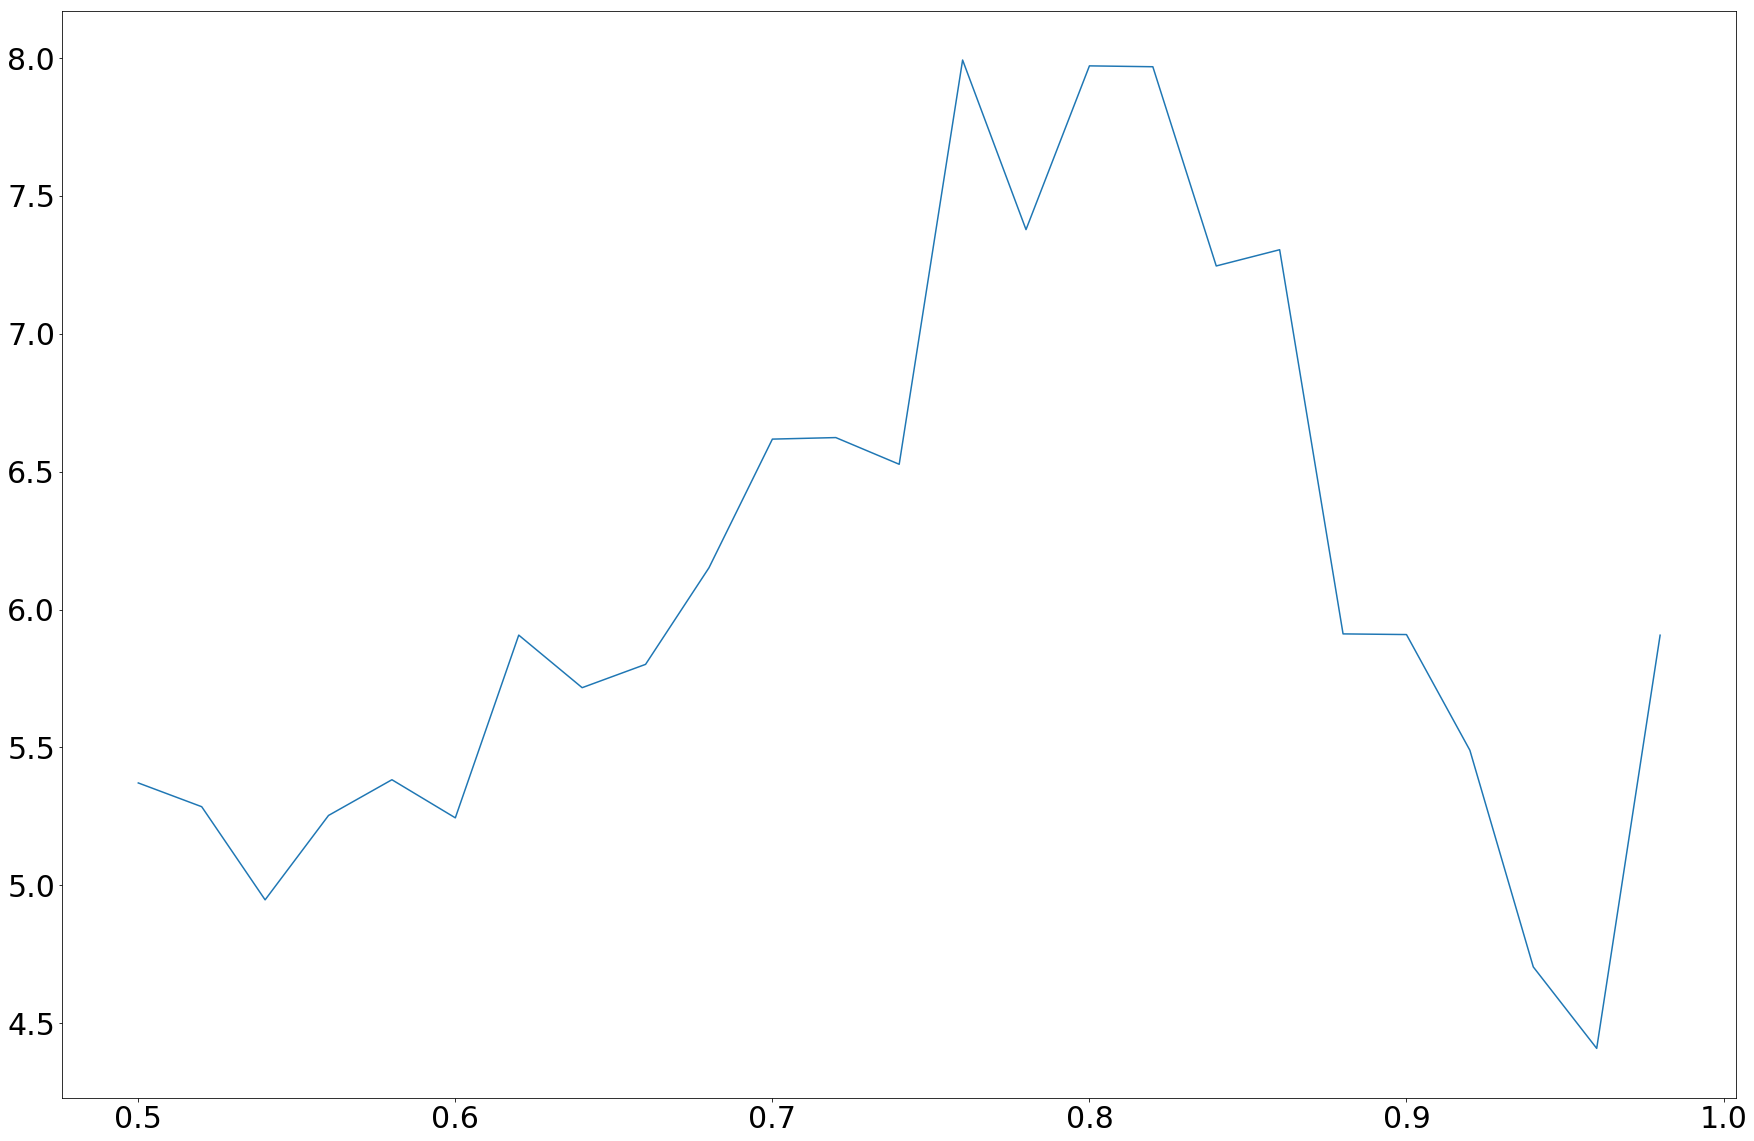

Sharp ratio:  OrderedDict([('sharperatio', 0.031536665921596485)])
Max drwadown:  AutoOrderedDict([('len', 38), ('drawdown', 1.7900541405373802), ('moneydown', 19472.457062298665), ('max', AutoOrderedDict([('len', 87), ('drawdown', 4.036267563023346), ('moneydown', 43627.21815679339)]))])
SQN: 0.9
Final Portfolio Value: 1068341.40 
Gain: 6.83
Sharp ratio:  OrderedDict([('sharperatio', 0.029292207106407852)])
Max drwadown:  AutoOrderedDict([('len', 38), ('drawdown', 1.8495116140578407), ('moneydown', 20011.457640298177), ('max', AutoOrderedDict([('len', 88), ('drawdown', 4.01754947902404), ('moneydown', 43308.633161792764)]))])
SQN: 0.93
Final Portfolio Value: 1061974.59 
Gain: 6.20
Sharp ratio:  OrderedDict([('sharperatio', 0.029497679229719426)])
Max drwadown:  AutoOrderedDict([('len', 38), ('drawdown', 1.9285642929520381), ('moneydown', 20888.469422599068), ('max', AutoOrderedDict([('len', 88), ('drawdown', 4.0212294199083125), ('moneydown', 43363.89450259111)]))])
SQN: 0.92
Final Po

Sharp ratio:  OrderedDict([('sharperatio', 0.05427192826060766)])
Max drwadown:  AutoOrderedDict([('len', 154), ('drawdown', 0.07681722898300863), ('moneydown', 821.6525761000812), ('max', AutoOrderedDict([('len', 154), ('drawdown', 2.776718239692009), ('moneydown', 29700.338387000025)]))])
SQN: 1.1
Final Portfolio Value: 1068798.52 
Gain: 6.88
Over: 4, t: 0.48


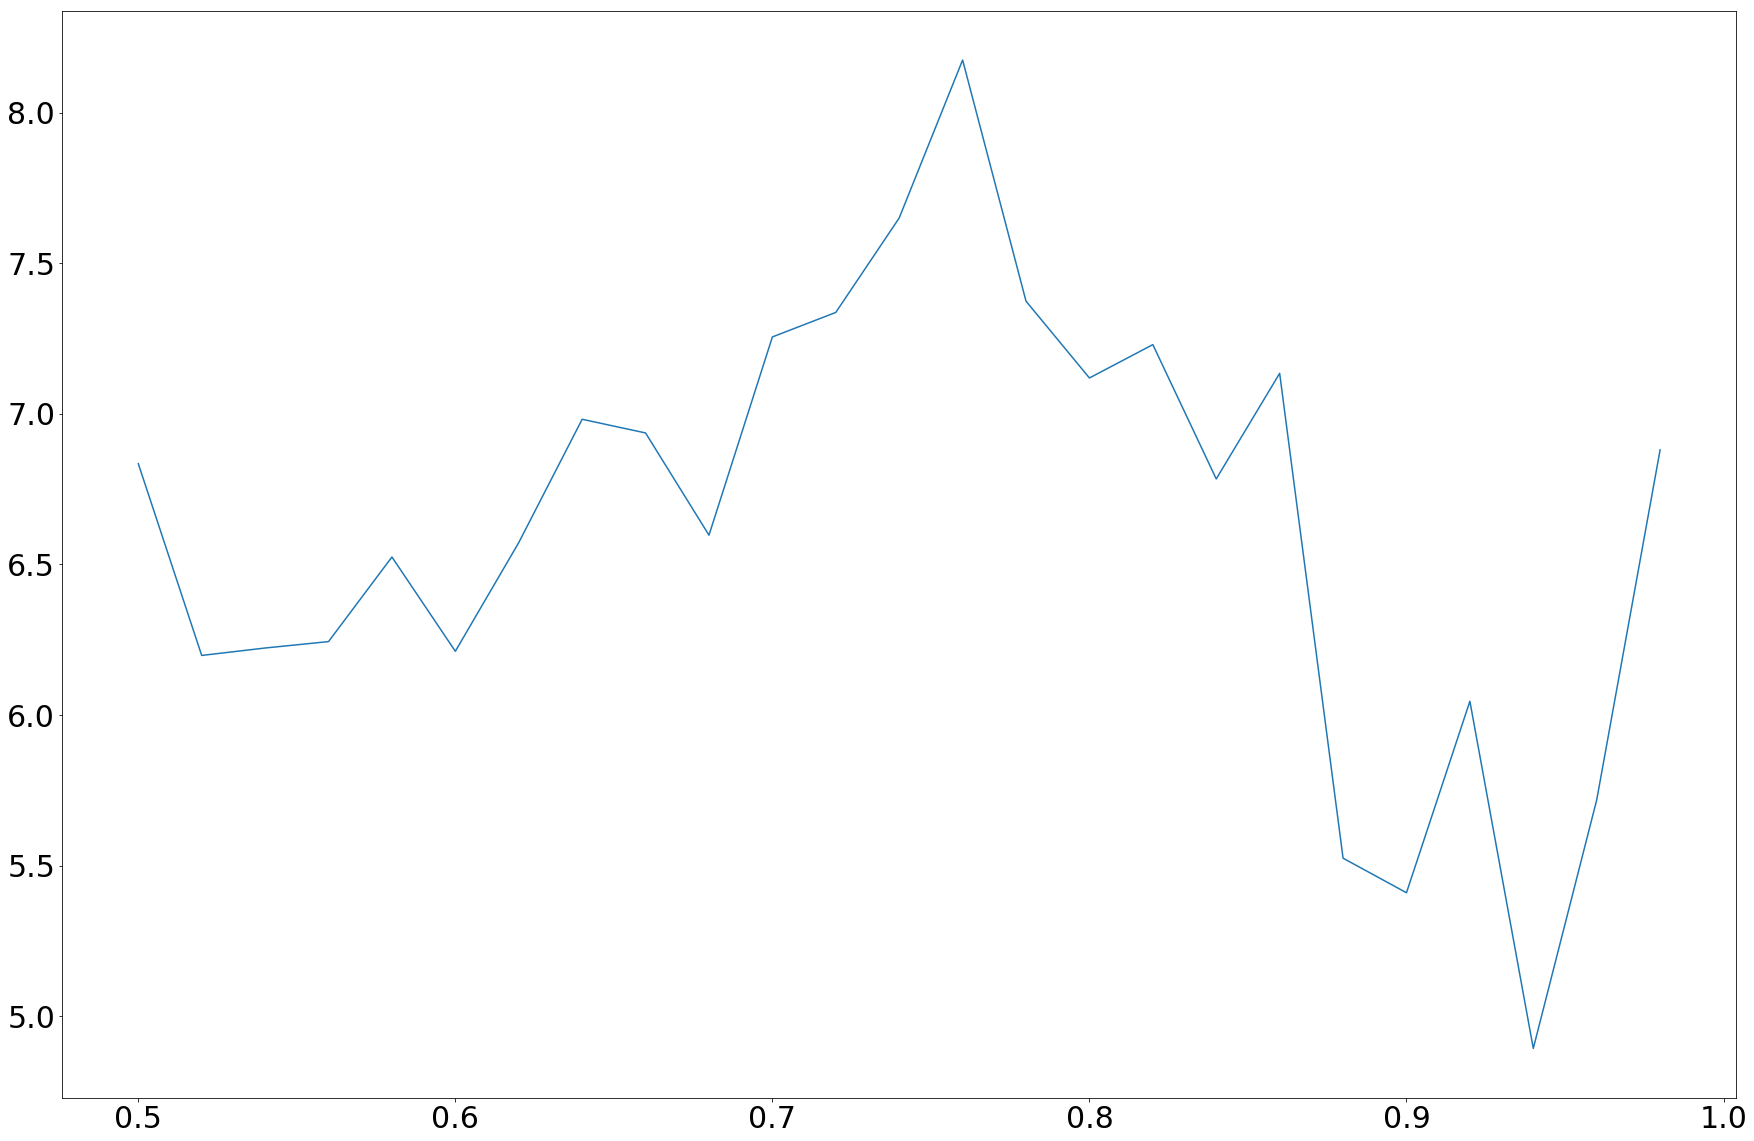

Sharp ratio:  OrderedDict([('sharperatio', 0.0317500588074202)])
Max drwadown:  AutoOrderedDict([('len', 38), ('drawdown', 1.9450466132242255), ('moneydown', 21189.340386698954), ('max', AutoOrderedDict([('len', 86), ('drawdown', 3.729414188922852), ('moneydown', 40267.233716193354)]))])
SQN: 1.25
Final Portfolio Value: 1068210.79 
Gain: 6.82
Sharp ratio:  OrderedDict([('sharperatio', 0.029757610103776897)])
Max drwadown:  AutoOrderedDict([('len', 38), ('drawdown', 1.8902661696073177), ('moneydown', 20464.719046700047), ('max', AutoOrderedDict([('len', 86), ('drawdown', 3.592531324225238), ('moneydown', 38578.716266191914)]))])
SQN: 1.29
Final Portfolio Value: 1062172.18 
Gain: 6.22
Sharp ratio:  OrderedDict([('sharperatio', 0.029076990972822927)])
Max drwadown:  AutoOrderedDict([('len', 38), ('drawdown', 1.9813145978230928), ('moneydown', 21427.139531699708), ('max', AutoOrderedDict([('len', 86), ('drawdown', 3.5701876925496077), ('moneydown', 38330.820472990745)]))])
SQN: 0.19
Final 

Sharp ratio:  OrderedDict([('sharperatio', 0.04743839614360385)])
Max drwadown:  AutoOrderedDict([('len', 154), ('drawdown', 0.6195674901711974), ('moneydown', 6572.398609000025), ('max', AutoOrderedDict([('len', 154), ('drawdown', 2.5477672145727963), ('moneydown', 27026.824297199957)]))])
SQN: 1.32
Final Portfolio Value: 1054231.91 
Gain: 5.42
Over: 8, t: 0.48


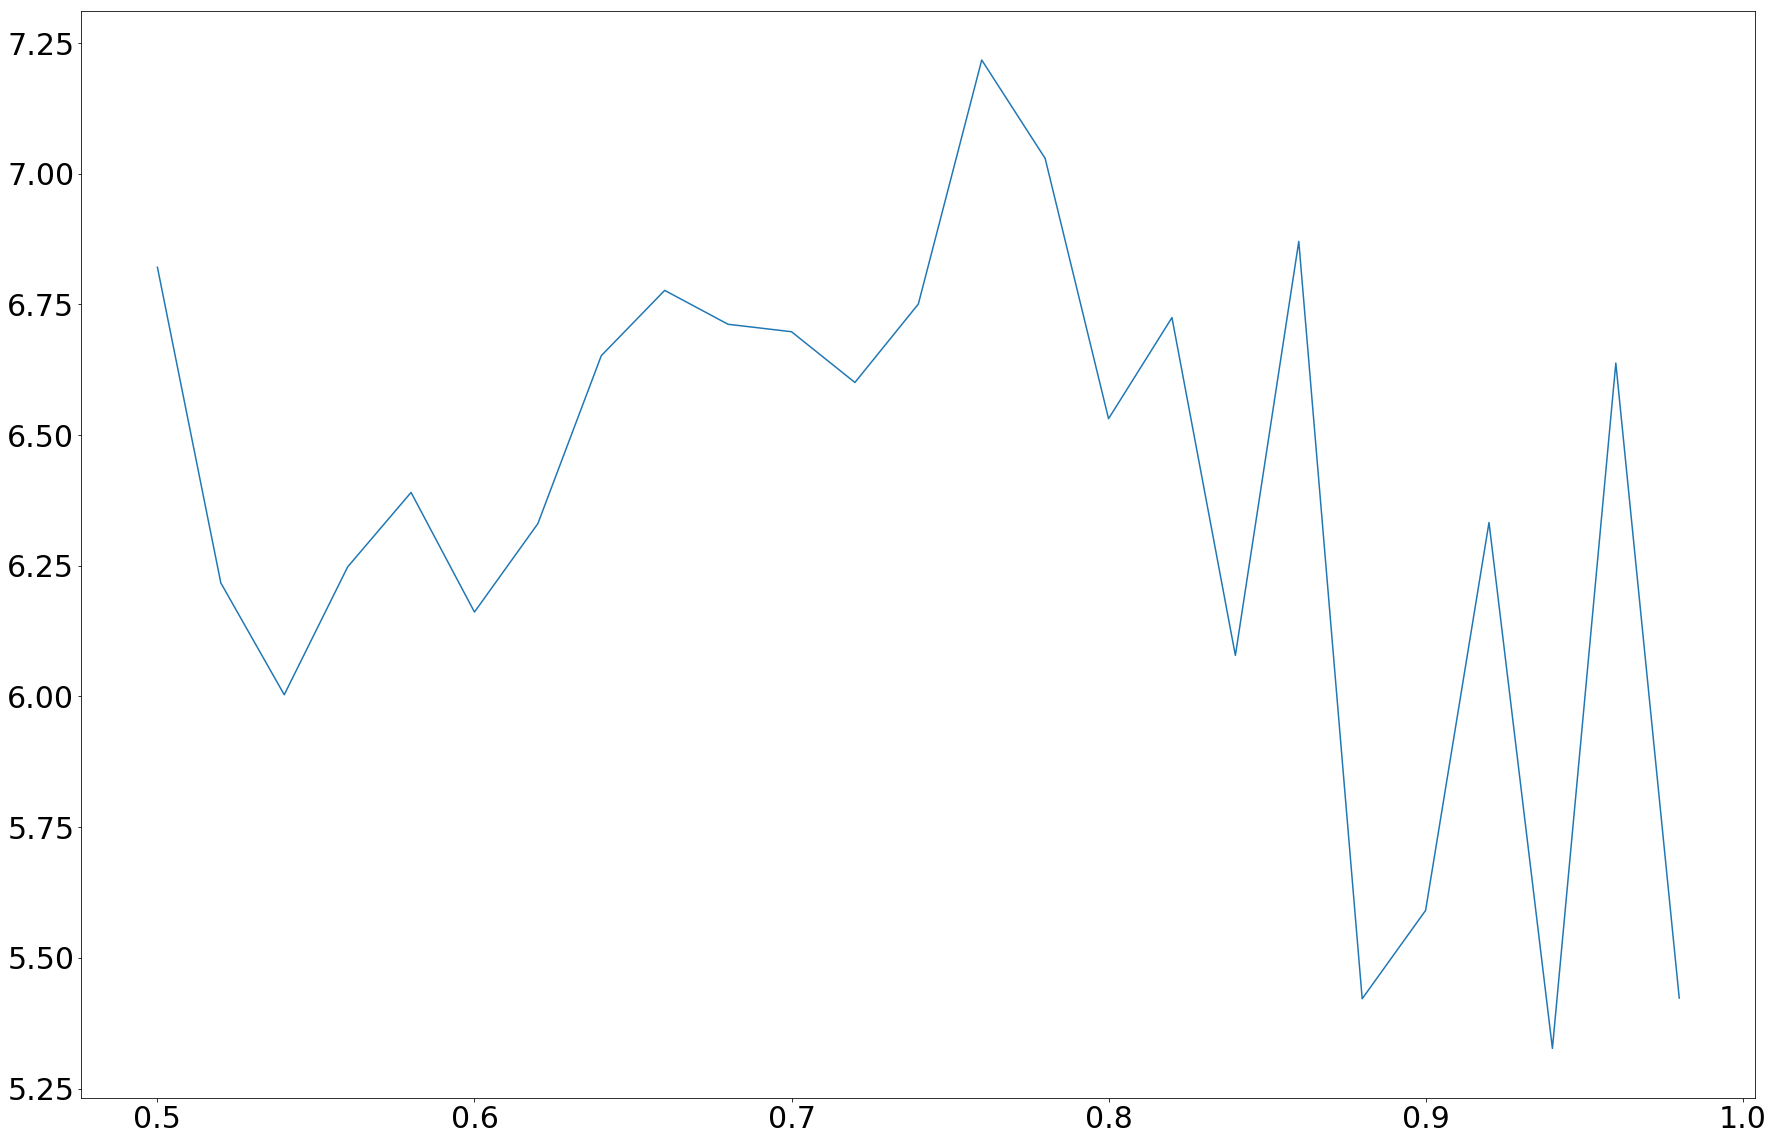

Sharp ratio:  OrderedDict([('sharperatio', 0.03163697977215953)])
Max drwadown:  AutoOrderedDict([('len', 38), ('drawdown', 1.65377959966165), ('moneydown', 17925.68406679947), ('max', AutoOrderedDict([('len', 85), ('drawdown', 3.48122918194073), ('moneydown', 37375.28560639499)]))])
SQN: 1.71
Final Portfolio Value: 1065996.51 
Gain: 6.60
Sharp ratio:  OrderedDict([('sharperatio', 0.031320586436009386)])
Max drwadown:  AutoOrderedDict([('len', 38), ('drawdown', 1.5025546912290912), ('moneydown', 16229.811338399304), ('max', AutoOrderedDict([('len', 88), ('drawdown', 3.21222028585033), ('moneydown', 34296.44121129147)]))])
SQN: 1.75
Final Portfolio Value: 1063917.98 
Gain: 6.39
Sharp ratio:  OrderedDict([('sharperatio', 0.031656292352285315)])
Max drwadown:  AutoOrderedDict([('len', 38), ('drawdown', 1.4384744577754789), ('moneydown', 15526.887827600585), ('max', AutoOrderedDict([('len', 90), ('drawdown', 3.265728863260566), ('moneydown', 34892.13985649799)]))])
SQN: 0.87
Final Portfoli

Sharp ratio:  OrderedDict([('sharperatio', 0.05226350527448352)])
Max drwadown:  AutoOrderedDict([('len', 155), ('drawdown', 0.2786055260678382), ('moneydown', 2948.4536071997136), ('max', AutoOrderedDict([('len', 155), ('drawdown', 2.0637813664455362), ('moneydown', 21840.7857886001)]))])
SQN: 1.75
Final Portfolio Value: 1055341.25 
Gain: 5.53
Over: 12, t: 0.48


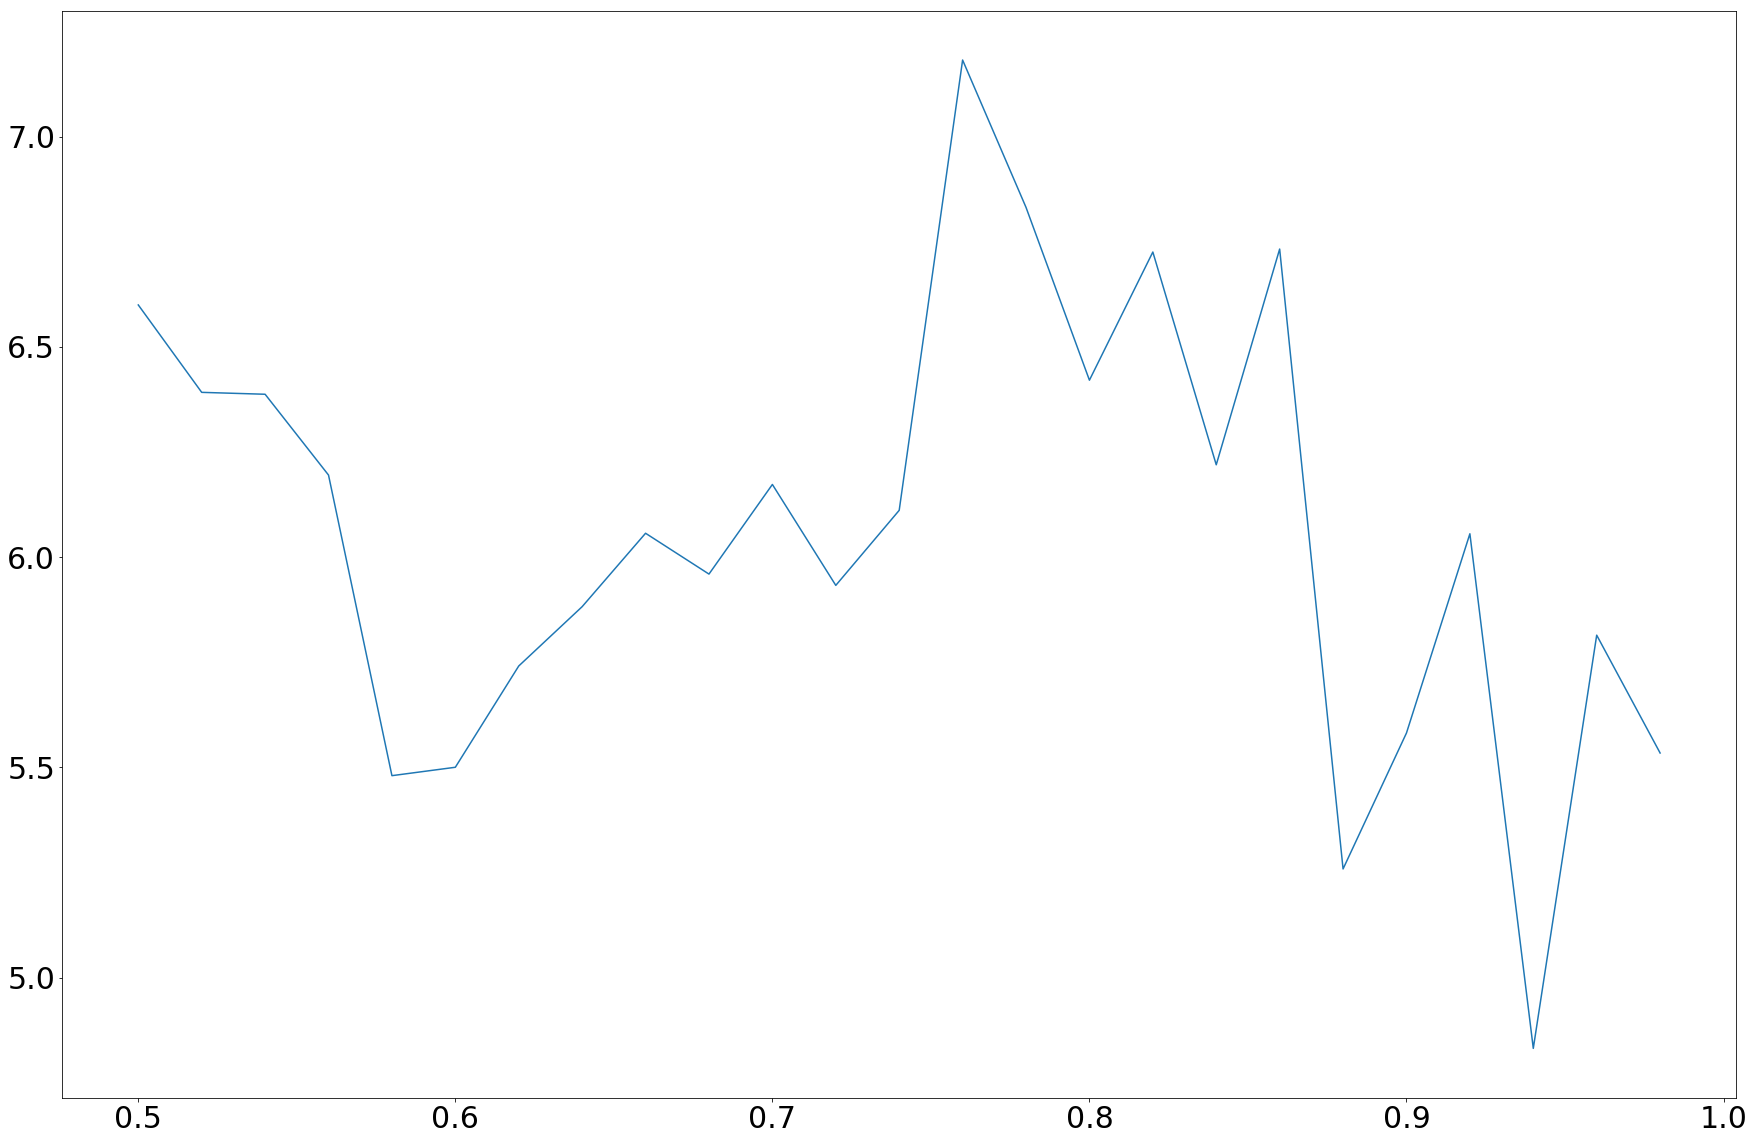

Sharp ratio:  OrderedDict([('sharperatio', 0.032785651886637394)])
Max drwadown:  AutoOrderedDict([('len', 38), ('drawdown', 1.4158272931767277), ('moneydown', 15298.708774499828), ('max', AutoOrderedDict([('len', 87), ('drawdown', 3.0667185867847904), ('moneydown', 32774.43620239361)]))])
SQN: 2.06
Final Portfolio Value: 1065250.37 
Gain: 6.53
Sharp ratio:  OrderedDict([('sharperatio', 0.034990977515817756)])
Max drwadown:  AutoOrderedDict([('len', 38), ('drawdown', 1.1755485292233934), ('moneydown', 12729.836459400365), ('max', AutoOrderedDict([('len', 87), ('drawdown', 2.691263654205541), ('moneydown', 28671.706225393806)]))])
SQN: 2.18
Final Portfolio Value: 1070154.97 
Gain: 7.02
Sharp ratio:  OrderedDict([('sharperatio', 0.0352532869268837)])
Max drwadown:  AutoOrderedDict([('len', 38), ('drawdown', 1.0391511753316525), ('moneydown', 11230.821551999776), ('max', AutoOrderedDict([('len', 87), ('drawdown', 2.6234382762343365), ('moneydown', 27878.636255392572)]))])
SQN: 1.1
Final P

Sharp ratio:  OrderedDict([('sharperatio', 0.052486520617960844)])
Max drwadown:  AutoOrderedDict([('len', 155), ('drawdown', 0.06912932601251813), ('moneydown', 728.8110714997165), ('max', AutoOrderedDict([('len', 155), ('drawdown', 1.8562908419386959), ('moneydown', 19570.353069599834)]))])
SQN: 1.36
Final Portfolio Value: 1053543.11 
Gain: 5.35
Over: 16, t: 0.48


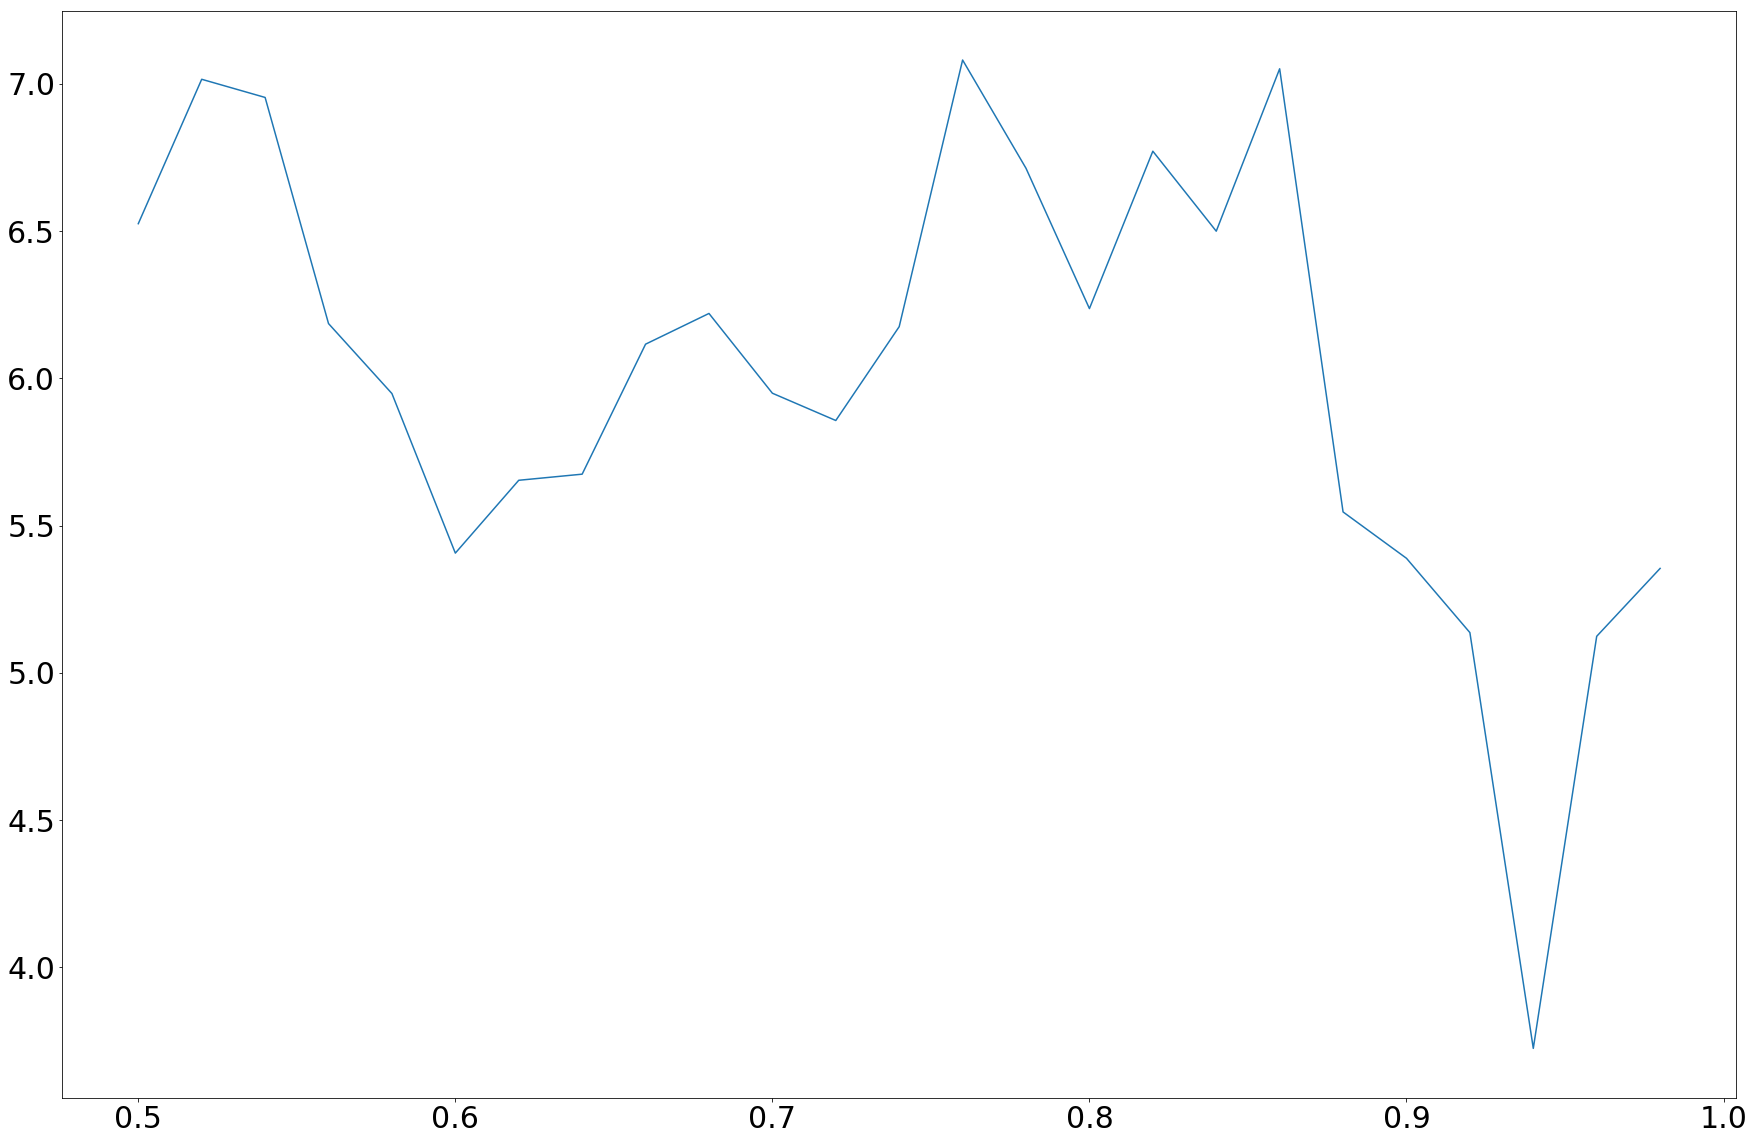

Sharp ratio:  OrderedDict([('sharperatio', 0.03318176008781167)])
Max drwadown:  AutoOrderedDict([('len', 38), ('drawdown', 1.3410844781072957), ('moneydown', 14442.515279399697), ('max', AutoOrderedDict([('len', 87), ('drawdown', 2.550538322167882), ('moneydown', 27080.52182429377)]))])
SQN: 1.86
Final Portfolio Value: 1062485.56 
Gain: 6.25
Sharp ratio:  OrderedDict([('sharperatio', 0.03558384184081661)])
Max drwadown:  AutoOrderedDict([('len', 38), ('drawdown', 0.8150678947925054), ('moneydown', 8774.40440909937), ('max', AutoOrderedDict([('len', 77), ('drawdown', 2.244728225883049), ('moneydown', 23698.491399396793)]))])
SQN: 0.93
Final Portfolio Value: 1067749.95 
Gain: 6.77
Sharp ratio:  OrderedDict([('sharperatio', 0.03704042007075973)])
Max drwadown:  AutoOrderedDict([('len', 38), ('drawdown', 0.8160796910607829), ('moneydown', 8804.81111490028), ('max', AutoOrderedDict([('len', 68), ('drawdown', 2.255801086492474), ('moneydown', 23742.364170906367)]))])
SQN: 1.31
Final Portfol

Sharp ratio:  OrderedDict([('sharperatio', 0.05635203149103737)])
Max drwadown:  AutoOrderedDict([('len', 15), ('drawdown', 0.05362587920651544), ('moneydown', 566.3035227998625), ('max', AutoOrderedDict([('len', 139), ('drawdown', 1.7688513636112222), ('moneydown', 18656.836610699655)]))])
SQN: 1.6
Final Portfolio Value: 1055460.25 
Gain: 5.55
Over: 20, t: 0.48


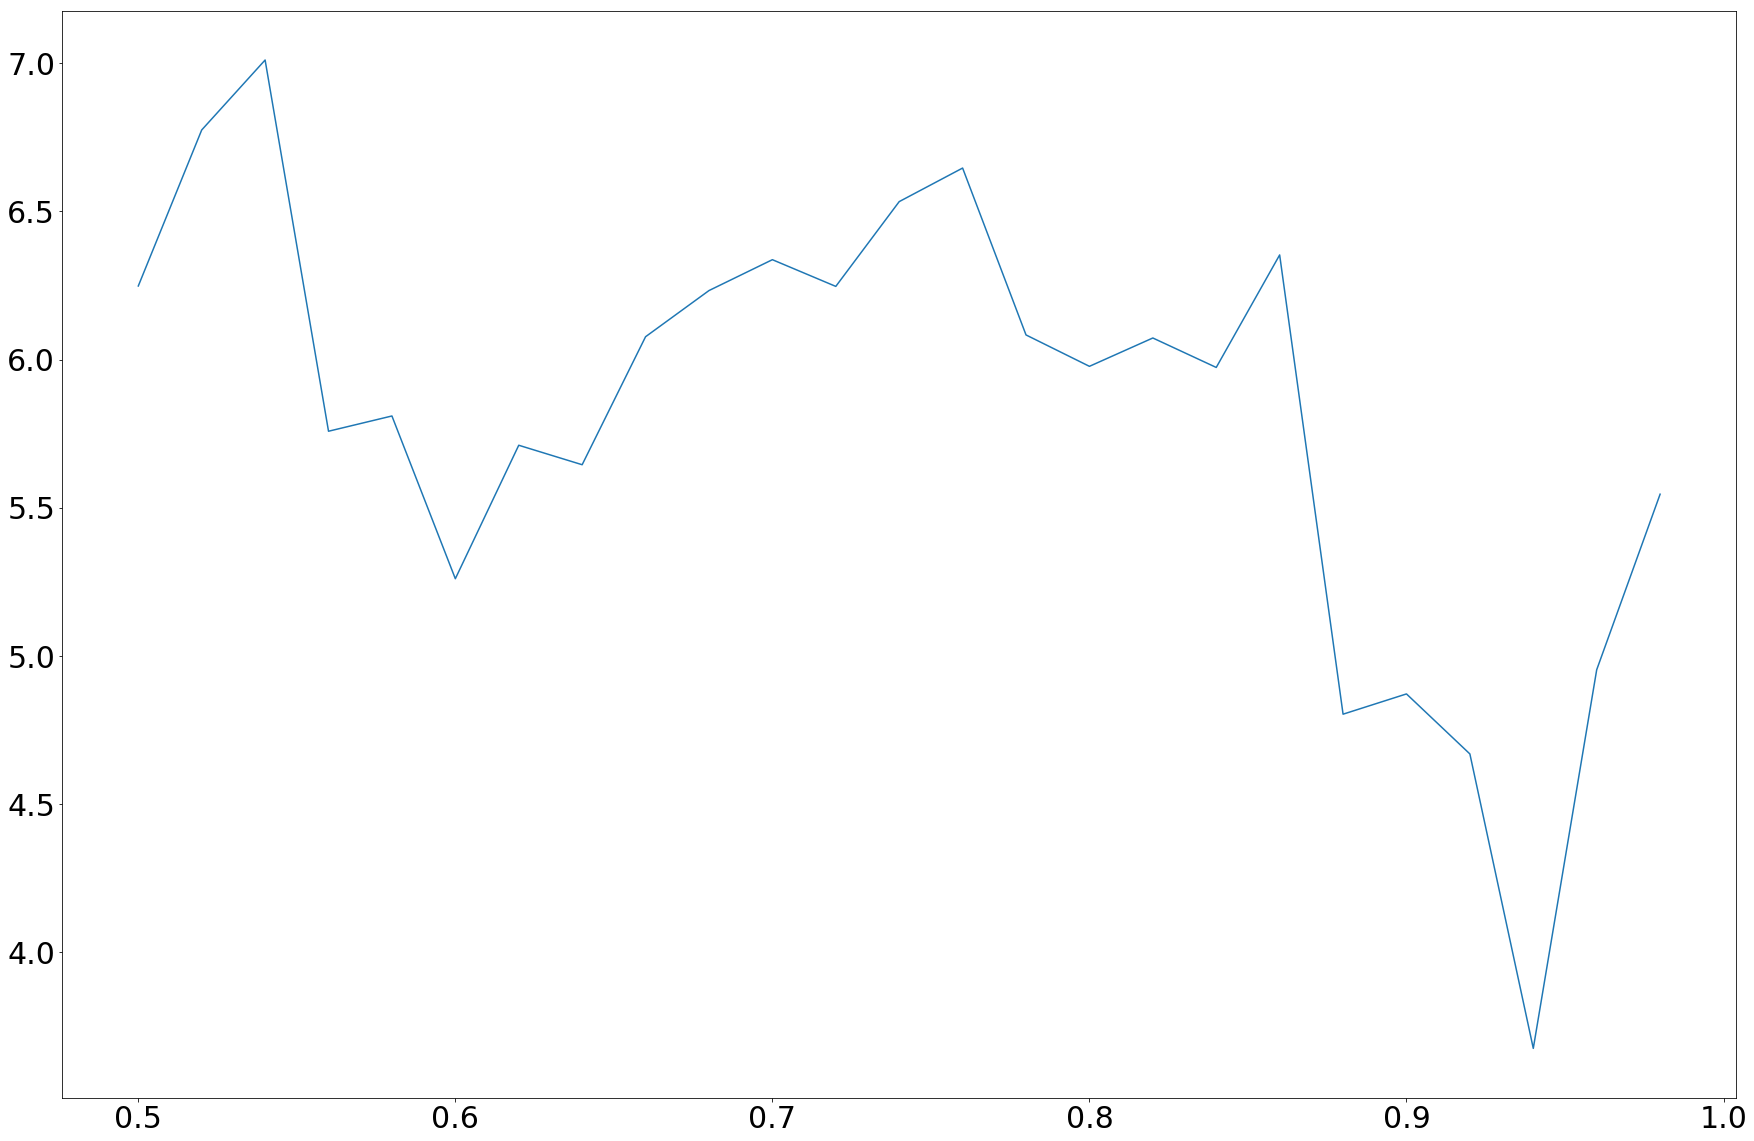

FINAL COMPARISON


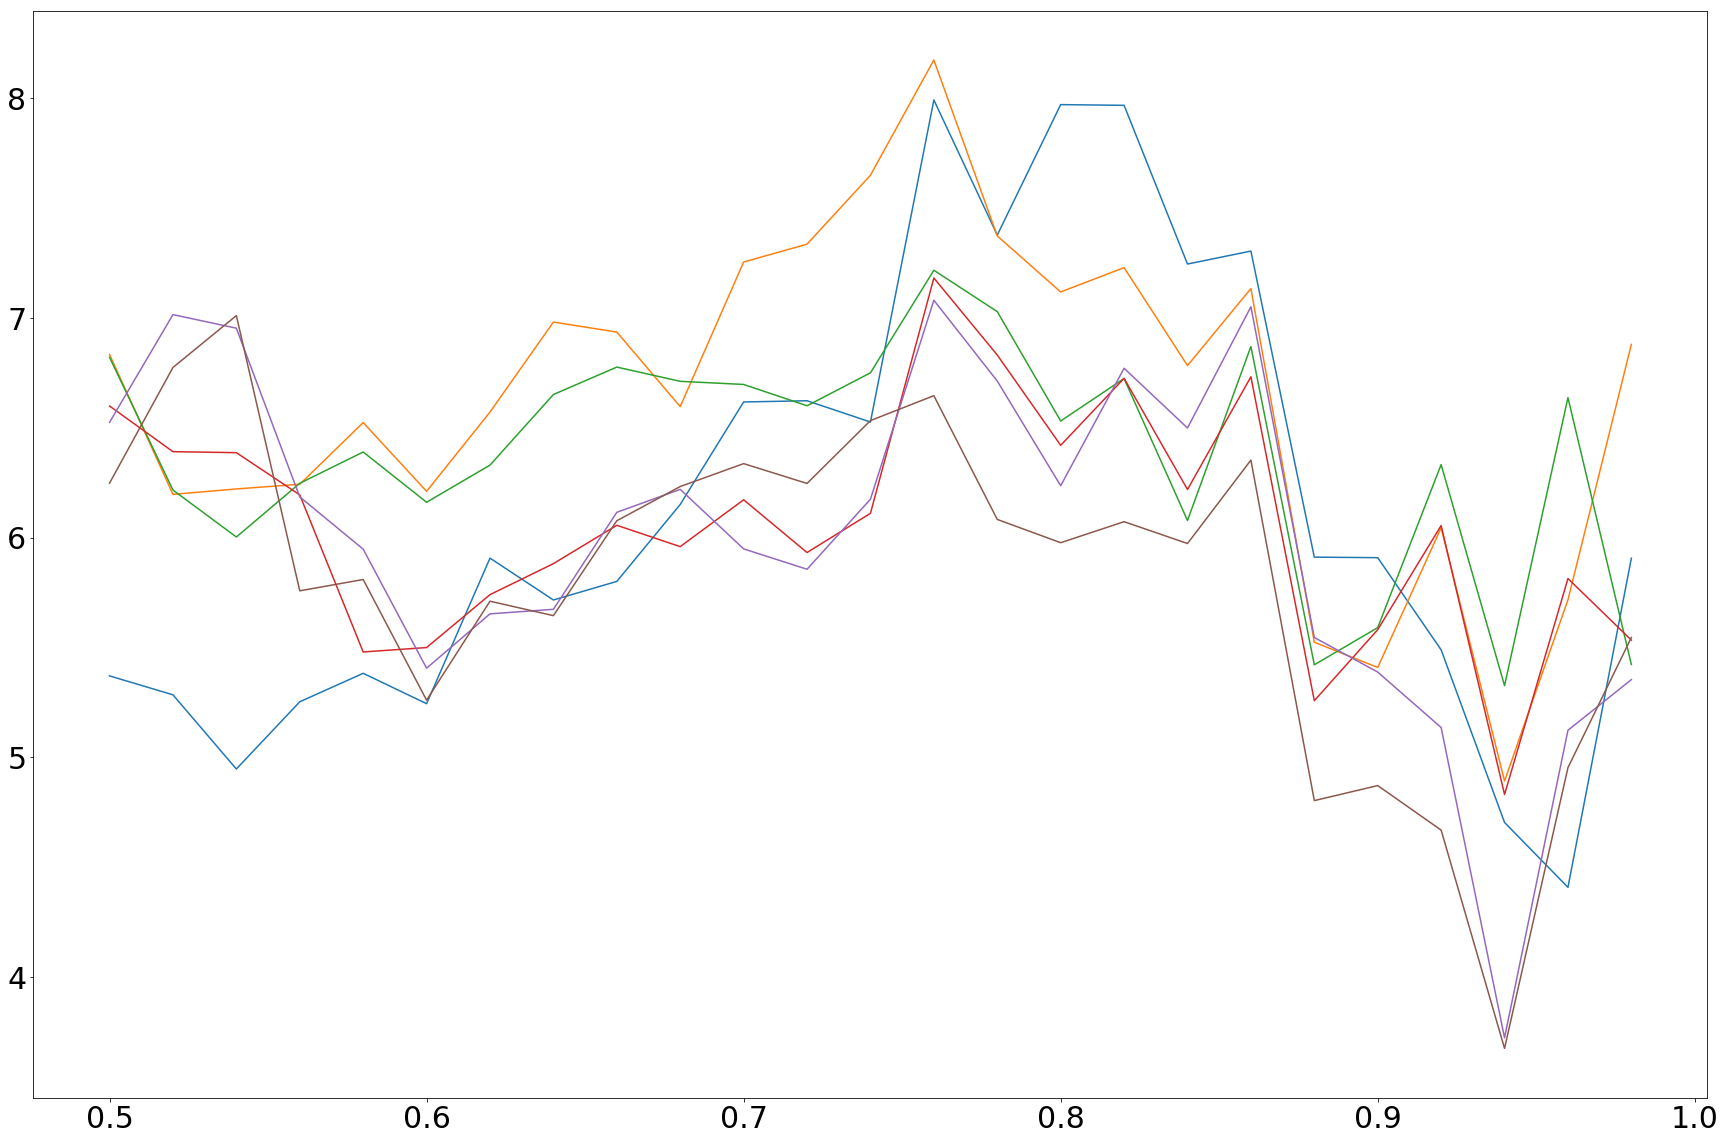

In [62]:
#NEWS
gainlist=list()
for over in [0,4,8,12,16,20]:
    gain=list()
    for t in np.arange(0,0.5,0.02):
        #print('Threshold: ',t)
        gain.append(simulation(t,over,1000000,tickers,1,'news'))
    print('Over: '+str(over)+', t: '+str(t))
    plt.plot(np.arange(0.5,1,0.02),gain)
    plt.show()
    gainlist.append(gain)
print('FINAL COMPARISON')
for el in range(0,len(gainlist)):
    plt.plot(np.arange(0.5,1,0.02),gainlist[el])
plt.show()

In [ ]:
for i in range(0,len(gainlist)):
    print(max(gainlist[i]))


In [ ]:
plt.plot(np.arange(0.5,1,0.02),gain)
plt.show()

In [ ]:
gain=list()
for t in np.arange(0,0.5,2.02):
    print('Threshold: ',t)
    gain.append(simulation(t,0,1000000,tickers,1))
plt.plot(np.arange(0.5,1,0.02),gain)
plt.show()

In [ ]:
gain=list()
for t in np.arange(0,0.5,5.02):
    print('Threshold: ',t)
    gain.append(simulation(t,0,1000000,tickers,1))
plt.plot(np.arange(0.5,1,0.02),gain)
plt.show()

In [ ]:
gain=list()
for t in np.arange(0,0.5,8.02):
    print('Threshold: ',t)
    gain.append(simulation(t,0,1000000,tickers,1))
plt.plot(np.arange(0.5,1,0.02),gain)
plt.show()

In [ ]:
gain=list()
for t in np.arange(0,0.5,12.02):
    print('Threshold: ',t)
    gain.append(simulation(t,0,1000000,tickers,1))
plt.plot(np.arange(0.5,1,0.02),gain)
plt.show()

In [ ]:
#do for one ticke time to make plot
for ticker in tickers:
    

    pred_threshold = 0.3        #buy if prediction more than this threshold (prediction values normalized 1: most secure prediction)
    num_pred_over_threshold = 5  #buy if more than this number of prediction over threshold
    init_value = 100000.0


    cerebro = bt.Cerebro(stdstats=False)
    cerebro.addobservermulti(bt.observers.BuySell)
    cerebro.addobserver(bt.observers.Broker)
    cerebro.addobserver(bt.observers.DrawDown)
    
   
    cerebro.broker.setcash(init_value)
    cerebro.broker.setcommission(commission=0.0001)
    predictions=list() 

    evenPlot = True
    
    temppred=pd.read_csv('/home/andrea/Desktop/NLFF/technicalAnalysis/NN/Predictions/Newsetting/both/'+ticker+'.csv')
    predictions.append(temppred)
    #plt.hist(temppred[ticker], bins = np.arange(0.0, 1.0, 0.01))
    #plt.show()
    dates_test = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in temppred['Unnamed: 0']]
    data = bt.feeds.GenericCSVData(
                dataname='/home/andrea/Desktop/NLFF/TechnicalDataset/GMT+0/'+ticker+'.csv',
                name=ticker,
                timeframe = bt.TimeFrame.Minutes, 
                compression = 15,
                datetime=1,open=2,high=3,low=4,close=5,volume=6,openinterest=-1,
                fromdate=dates_test[0],
                todate=dates_test[-1]+timedelta(minutes=1),
                reverse=False)
#         if(evenPlot):
#             data0 = data
#             evenPlot = False
#         else:
#             data.plotinfo.plotmaster = data0
#             evenPlot = True
    cerebro.adddata(data)

    #cerebro.addsizer(Sizer)    
     #Up to now only future
    cerebro.addstrategy(Strategy,
                        pred_threshold = pred_threshold,
                        num_pred_over_threshold = num_pred_over_threshold,
                        forecast_window=140,
                        predictions = predictions,
                        verbose = True)
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="ta")
    cerebro.addanalyzer(bt.analyzers.SQN, _name="sqn")
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe',timeframe=bt.TimeFrame.Minutes, compression=15) 
    print('Starting Portfolio Value: %.2f' % init_value)
    strategy = cerebro.run()[0]
    final_value = cerebro.broker.getvalue()
    cerebro.plot()
    
    printTradeAnalysis(strategy.analyzers.ta.get_analysis())
    print(strategy.analyzers.sharpe.get_analysis())
    printSQN(strategy.analyzers.sqn.get_analysis())
    print('Final Portfolio Value: %.2f \nGain: %.2f' % (final_value, (100*(final_value-init_value))/init_value))

In [ ]:
## MARKET PERFORMANCE:
class BuyAndHold(bt.Strategy):
    def log(self, txt, dt=None):
        dt = dt or self.datetime.datetime().strftime('%Y-%m-%d %H:%M:%S')
        print('%s, %s' % (dt, txt))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)
      
    def __init__(self):
        return

    def next(self): 
        for i, d in enumerate(self.datas):
            self.buy(data = d, size=1)                


init_value = 3670.0 #Correct value to buy one stock a the beginning
init_value = 100000

for (init, finish) in TREND_WINDOWs:
    print('\n====================  trend: ',init,' ',finish, ' ==================== \n')
    cerebro = bt.Cerebro()
    cerebro.broker.setcash(init_value)
    cerebro.broker.setcommission(commission=0.0001)
    predictions = pd.read_csv('testPredictions/AllTickers_'+str(init)+'_'+str(finish)+'.csv', index_col = 0)
    dates_test = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in predictions.index]
    for ticker in tickers:
        data = bt.feeds.GenericCSVData(
                    dataname='/home/simone/Desktop/NLFF/indexes/indexes'+ticker+'.csv',
                    name=ticker,
                    timeframe = bt.TimeFrame.Minutes, 
                    compression = 60,
                    datetime=1,open=2,high=3,low=4,close=5,volume=6,openinterest=-1,
                    fromdate=dates_test[0],
                    todate=dates_test[-1]+timedelta(minutes=1),
                    reverse=False)
        cerebro.adddata(data)
        
    cerebro.addstrategy(BuyAndHold)
    cerebro.addanalyzer(bt.analyzers.SQN, _name="sqn")
    print('Starting Portfolio Value: %.2f' % init_value)
    strategy = cerebro.run()[0]
    final_value = cerebro.broker.getvalue()
    print('Final Portfolio Value: %.2f \nGain: %.2f' % (final_value, final_value/init_value - 1))